<a href="https://colab.research.google.com/github/HagerArafat/assignment-CNN-LSTM-/blob/main/ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

print("GPU available: ", tf.config.list_physical_devices('GPU'))


GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

data_dir = '/content/drive/MyDrive/asl_dataset/'

IMG_SIZE = 64
timesteps = 10

X = []
y = []
labels = sorted([label for label in os.listdir(data_dir) if label != 'asl_dataset'])
label_map = {label: idx for idx, label in enumerate(labels)}

for label in labels:
    folder_path = os.path.join(data_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label_map[label])

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

#One-hot encoding
y = to_categorical(y, num_classes=len(labels))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


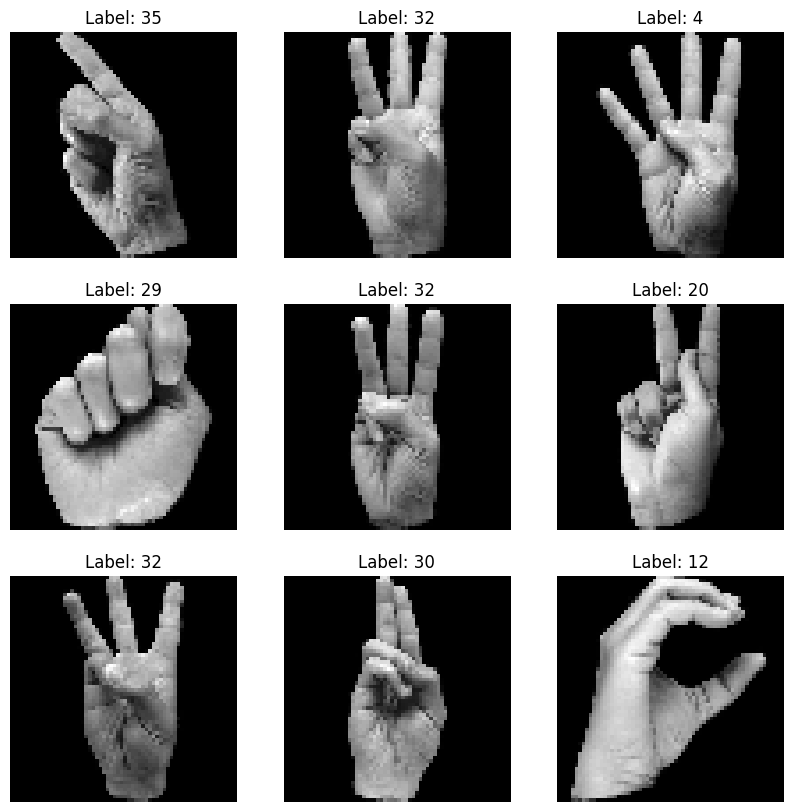

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

input_shape = (timesteps, IMG_SIZE, IMG_SIZE, 1)

model = Sequential()


model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))


model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 64, 64, 32)      │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 32, 32, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 16384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       8,454,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,494,628 (32.40 MB)

 Trainable params: 8,494,628 (32.40 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.0850 - loss: 3.4086 - val_accuracy: 0.1948 - val_loss: 2.8106
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2226 - loss: 2.6692 - val_accuracy: 0.2525 - val_loss: 2.4120
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.2732 - loss: 2.3542 - val_accuracy: 0.3320 - val_loss: 2.1633
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.3574 - loss: 2.0798 - val_accuracy: 0.3539 - val_loss: 1.9624
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4077 - loss: 1.9069 - val_accuracy: 0.4851 - val_loss: 1.7243
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.4691 - loss: 1.6539 - val_accuracy: 0.5328 - val_loss: 1.4949
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5528 - loss: 1.4153 - val_accuracy: 0.5905 - val_loss: 1.2766
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5991 - loss: 1.3072 - val_accuracy: 0.6302 

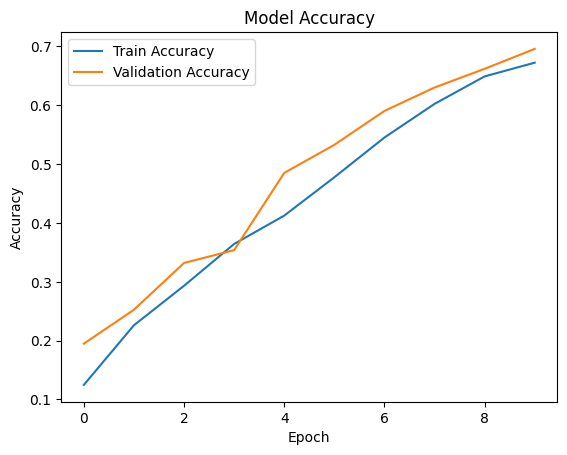

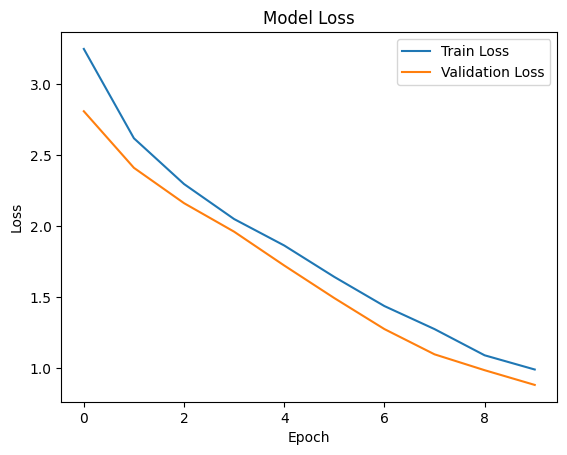

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6816 - loss: 0.9183
Test accuracy: 69.58%


In [ ]:
model.save('asl_cnn_lstm_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('asl_cnn_lstm_model.keras', compile=False)
